In [2]:
import pyvista as pv
import numpy as np

import currio
from currio.neuron import Neuron
from currio.sensor import RegularGridSensor
from currio.diamond import NV
from currio.io import IO
import currio.io as io
from currio.plot import plot
from currio.utils import nrndir, parse_time_range
from currio.compiled import get_b_njit

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
n = Neuron(55035)

	1 
	1 
	1 
	1 
	0 
	1 
	1 
	1 
	1 
	1 
	1 
	0 
	1 
	1 
	0 
	0 
	0 
	0 
	1 
	0 
	1 
	1 
	1 
	1 


In [5]:
n.get_3d_mesh().plot(notebook=False)

In [19]:
sec_name = "apical_dendrite[13]"
sec = n.get(sec_name)

In [5]:
n.simulate("runm", force=True, track_vars=[
    "*.v", "apical_dendrite[13].ina", "apical_dendrite[13].ik",
    "apical_dendrite[13].i_pas",
    "apical_dendrite[13].i_cap",
    "apical_dendrite[13].ica",
    "apical_dendrite[13].il_cc",
    "apical_dendrite[13].i_membrane_",
    "apical_dendrite[13].i_membrane",
    "apical_dendrite[13].i_hd",
    "apical_dendrite[13].i_membrane_",
    "apical_dendrite[13].il_hh",
    ])



Neuron `55035` with 1 Record
    Record `runm` with 414 time points in t=[0.0, 20.0] ms, recorded values: i_cap, i_hd, i_membrane, i_membrane_, i_pas, ica, ik, il_cc, il_hh, ina, v

In [98]:
print("Section name: ", sec_name)
print("Section diameter: ", sec.diam, "um")
print("Section length: ", sec.L, "um")

# Length of the section is too large to be representative of the currents 
# at the length scale of microns, so we will use a smaller section length:
length = 1  # um

membrane_area = sec.diam * length * np.pi
print("Membrane area: ", membrane_area, "um^2")

Section name:  apical_dendrite[13]
Section diameter:  1.3500000238418577 um
Section length:  81.30752612643231 um
Membrane area:  4.241150157247626 um^2


In [7]:
n.calculate_currents()

Neuron `55035` with 1 Record
    Record `runm` with 414 time points in t=[0.0, 20.0] ms, recorded values: currents, i_cap, i_hd, i_membrane, i_membrane_, i_pas, ica, ik, il_cc, il_hh, ina, interp_v, v

In [218]:
n.record[sec_name]["currents"].shape

(15, 414)

In [222]:
plt.close()

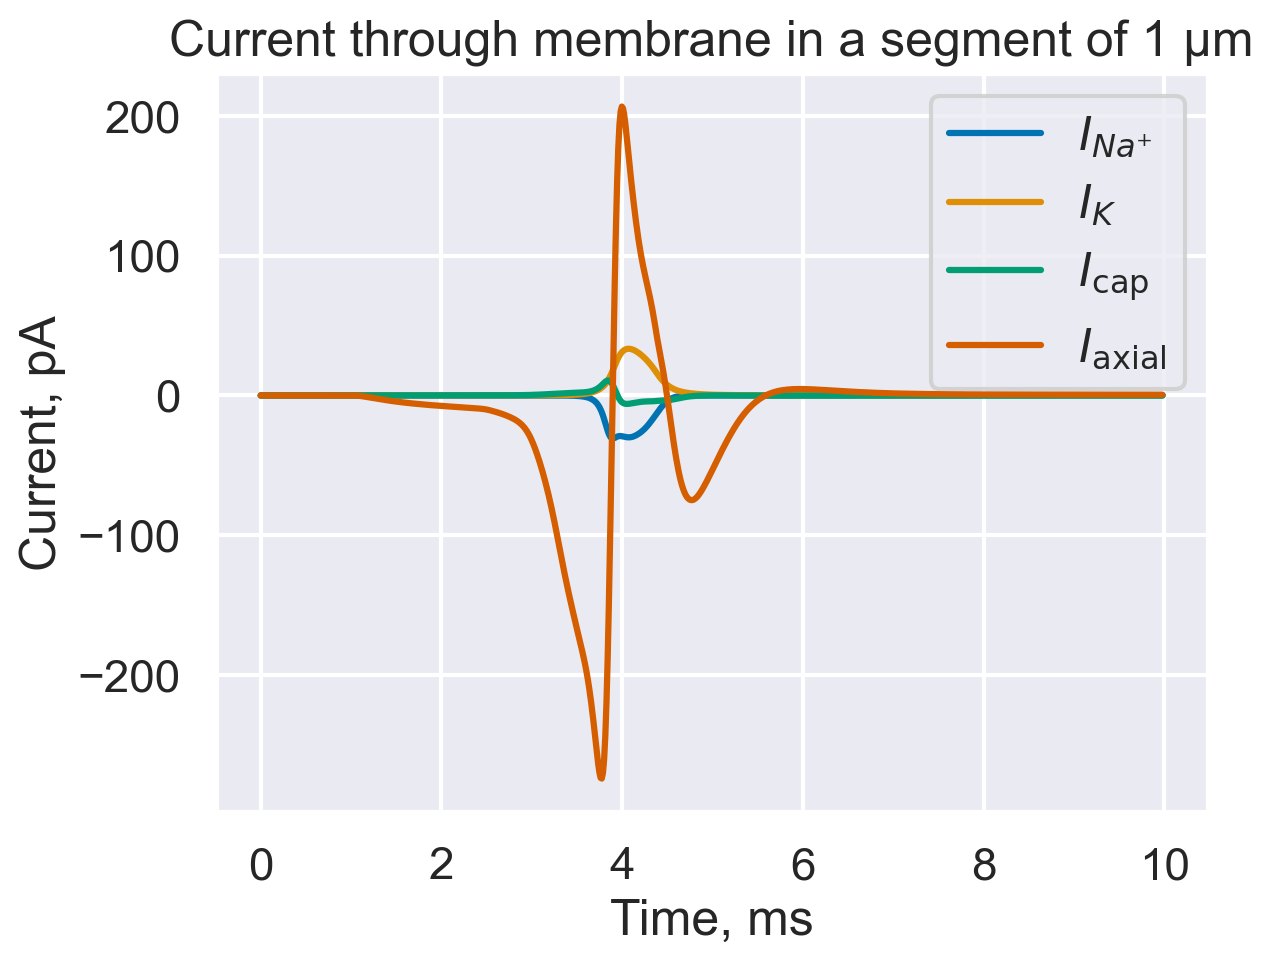

In [229]:
ts = n.record["t"]
sl = parse_time_range("0..10ms", ts)
ts = ts[sl]

# We want to convert currents per unit area in mA/cm^2 to the 
# current through a 1 um long section with a given diameter, i.e.
# to multiply this number by um^2. Conversion is
# mA/cm^2 * um^2 * 10^-8 = mA  
# 
# We can make it to pA = 10^-9 mA 
cf = 10

# sns.set_style("darkgrid")
sns.set_context("talk")
sns.set_palette("colorblind")
sns.set_style("darkgrid")

# by default current are in mA, to convert to pA, we multiply by 10⁹
axial_currents = n.record[sec_name]["currents"][1, sl] * 10 ** 9




plt.plot(ts, membrane_area * n.record[sec_name]["ina"][1, sl] * cf, label=r"$I_{Na⁺}$")
plt.plot(ts, membrane_area * n.record[sec_name]["ik"][1, sl] * cf, label=r"$I_K$")
plt.plot(ts, membrane_area * n.record[sec_name]["i_cap"][1, sl] * cf, label=r"$I_\text{cap}$")
plt.plot(ts, axial_currents, label=r"$I_\text{axial}$")
# plt.plot(ts, n.record[sec_name]["i_pas"][1, sl], label=r"$i_\text{pas}$")
# plt.plot(ts, n.record[sec_name]["i_hd"][1, sl], label=r"$i_\text{hd}$")
plt.title("Current through membrane in a segment of 1 μm")
plt.ylabel(r"Current, pA")
plt.xlabel("Time, ms")
plt.legend()
plt.show()

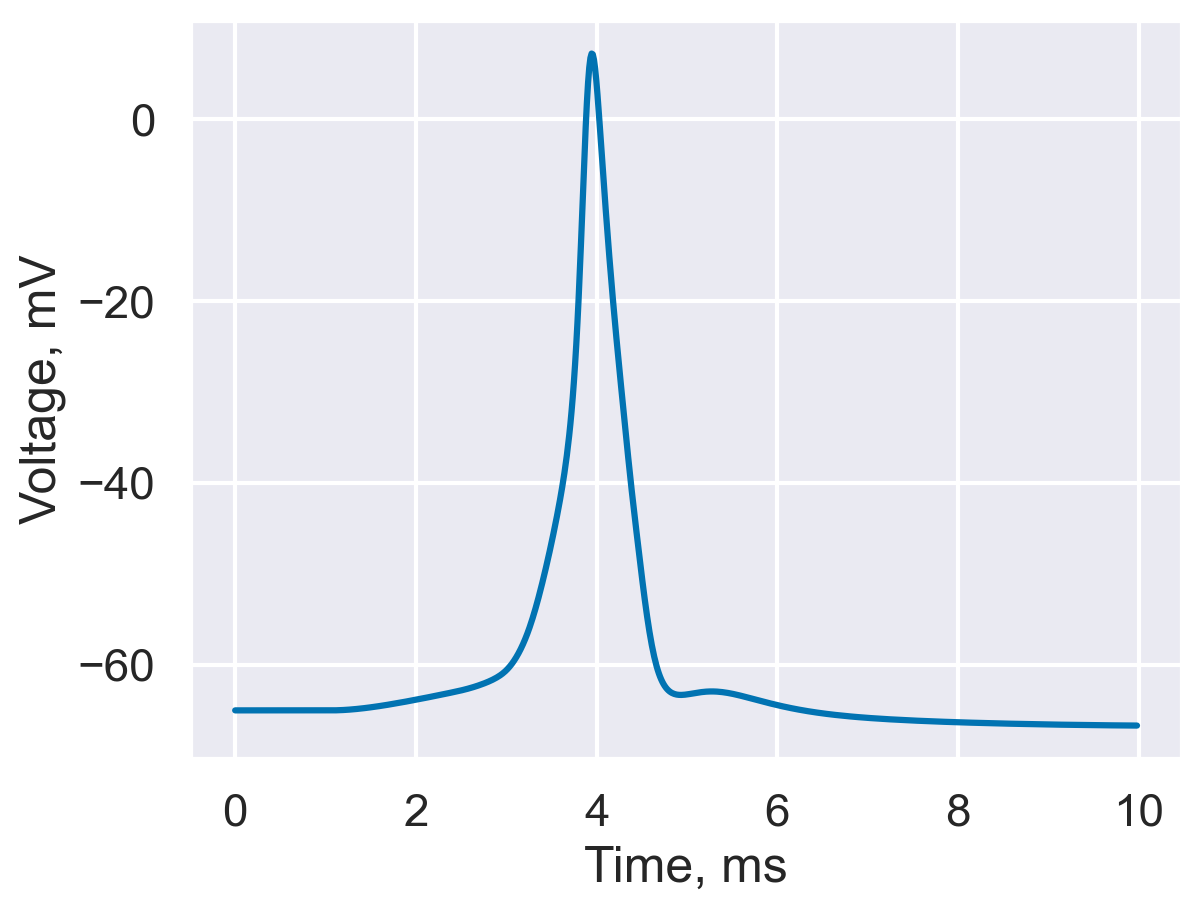

In [234]:
sns.set_context("talk")
sns.set_palette("colorblind")
sns.set_style("darkgrid")

# by default current are in mA, to convert to pA, we multiply by 10⁹
voltages = n.record[sec_name]["v"][1, sl]

plt.plot(ts, voltages, label=r"$V$")
# plt.plot(ts, n.record[sec_name]["i_pas"][1, sl], label=r"$i_\text{pas}$")
# plt.plot(ts, n.record[sec_name]["i_hd"][1, sl], label=r"$i_\text{hd}$")
plt.ylabel(r"Voltage, mV")
plt.xlabel("Time, ms")
plt.show()

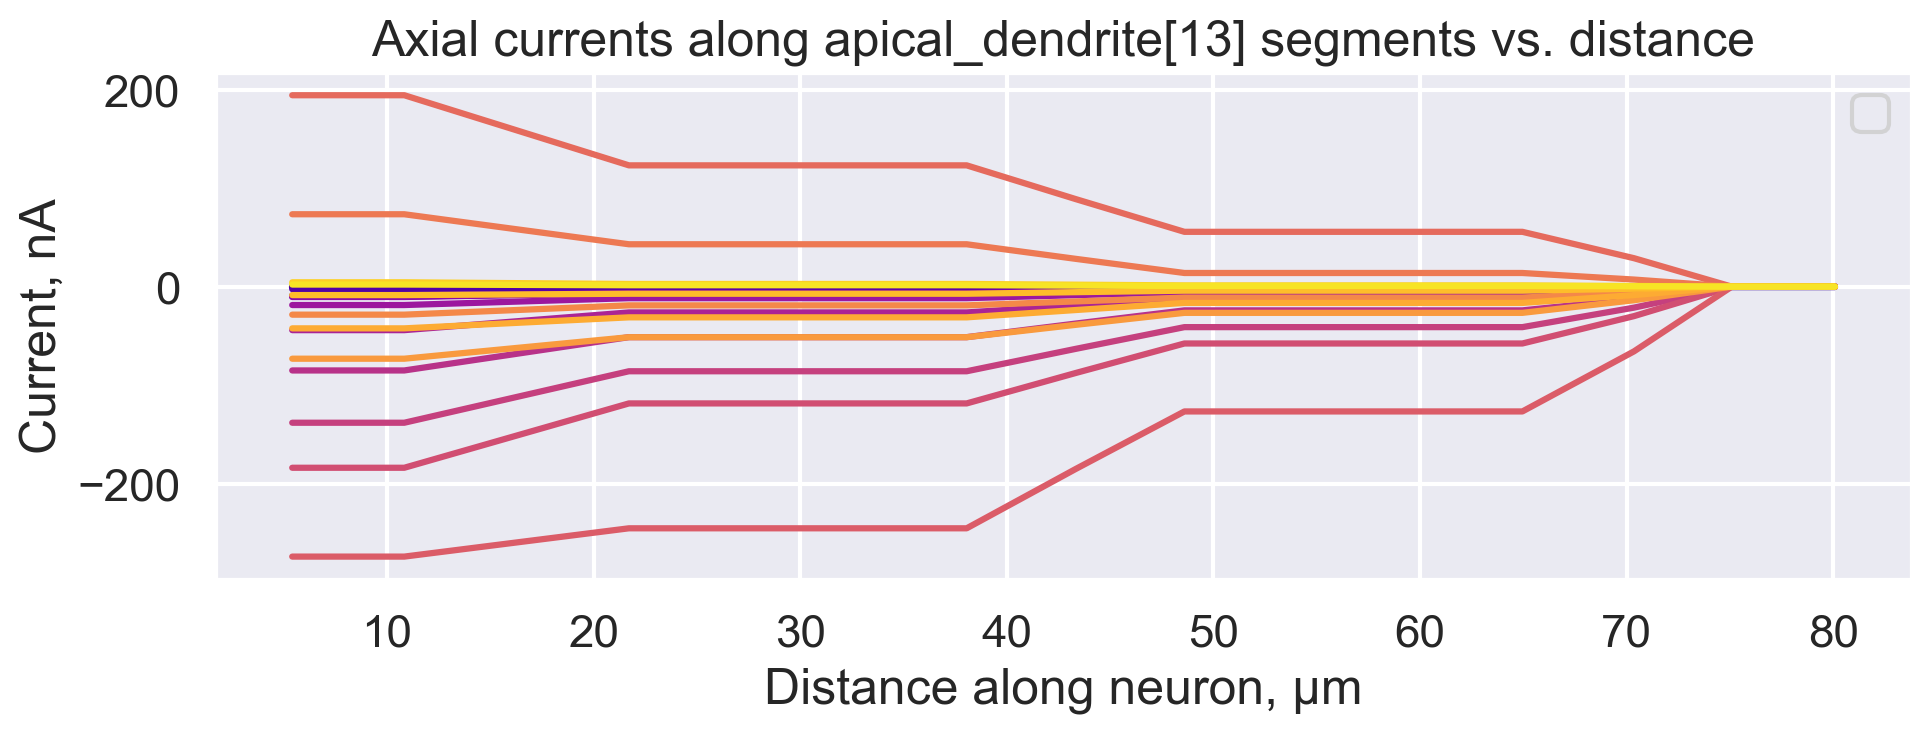

In [261]:


# Set name of the section to plot   
section_name = "apical_dendrite[13]"
ls = np.array(n.mesh[section_name].field_data["arc_length"])

# Create figure with larger size for better visibility
plt.figure(figsize=(10, 4))

# Get number of segments
n_segments = n.record[section_name]["currents"].shape[0]

n_times = 20
n_time_points = n.record["t"].shape[0]
time_points = np.arange(0, n_time_points, n_times)

# Create color palette that varies sequentially
colors = sns.color_palette("plasma", n_times)

# Plot each segment with different color
with sns.axes_style("darkgrid"):
    for j in range(n_times):
        currents = n.record[section_name]["currents"][:, time_points[j]]  # mA
        currents = currents * 1e9  # convert mA → pA
        sns.lineplot(x=ls[1:], 
                    y=currents,
                    color=colors[j], 
                    label=f'Segment {j}')

# Customize plot
plt.xlabel('Distance along neuron, μm')
plt.ylabel('Current, nA')
plt.title('Axial currents along {} segments vs. distance'.format(section_name))

# Remove legend
plt.legend([])

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

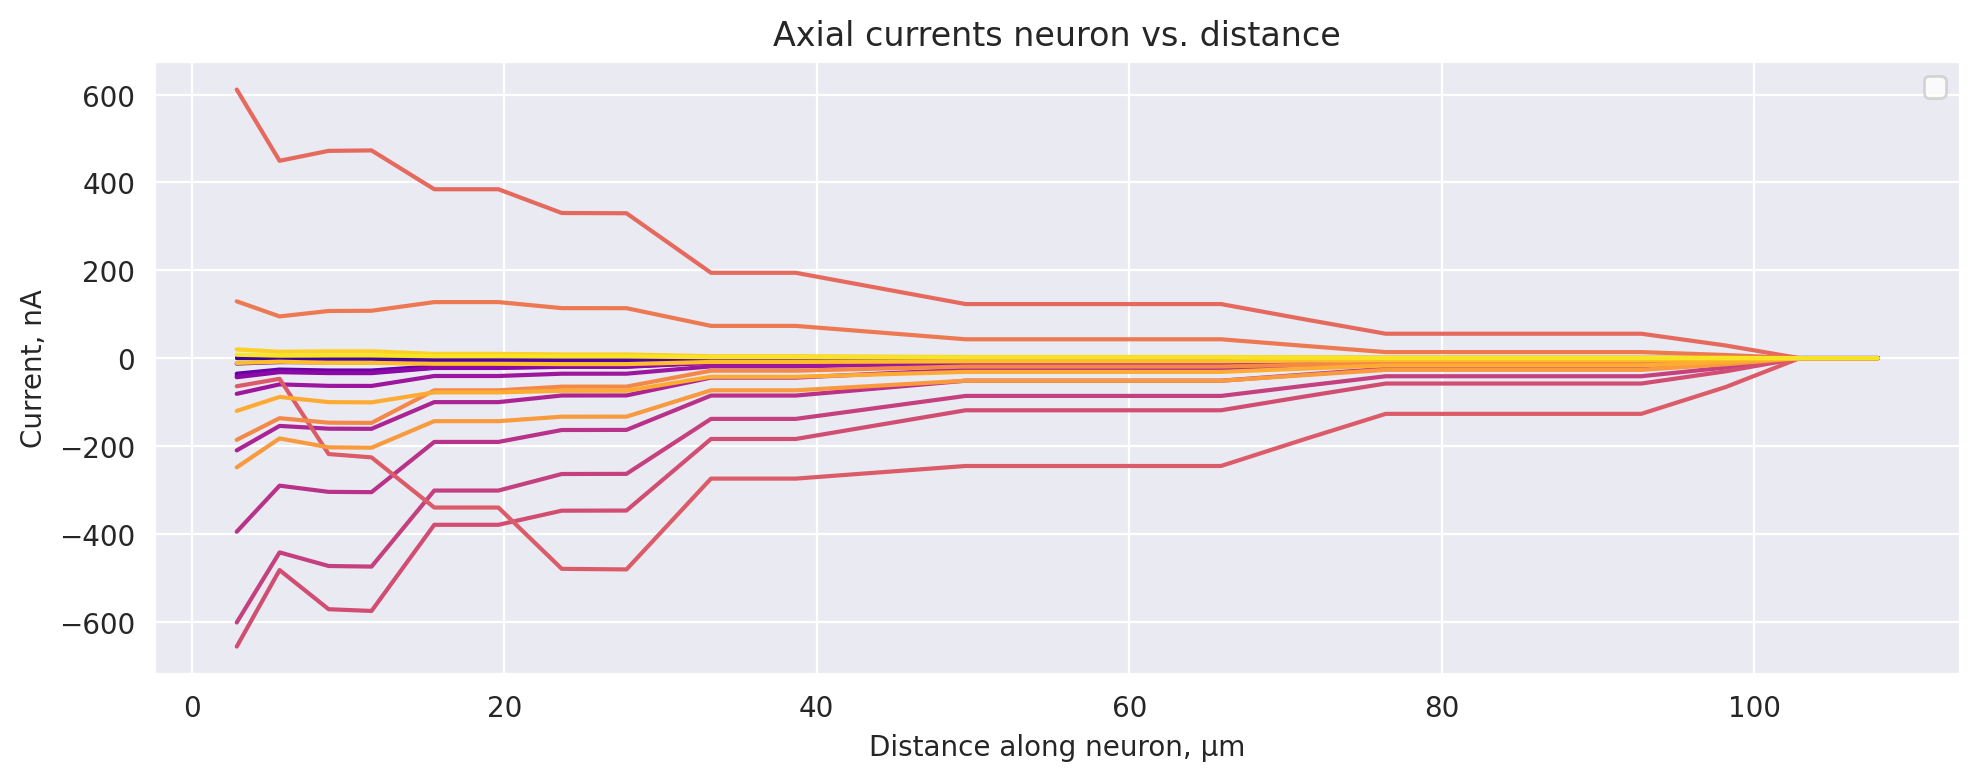

In [8]:
# Set names of the sections to plot   
section_name = "apical_dendrite[13]"
parent_section = n.get(section_name).trueparentseg().sec.hname()
grandparent_section = n.get(parent_section).trueparentseg().sec.hname()

# Get arc lengths for both sections
ls_current = np.array(n.mesh[section_name].field_data["arc_length"])
ls_parent = np.array(n.mesh[parent_section].field_data["arc_length"])
ls_grandparent = np.array(n.mesh[grandparent_section].field_data["arc_length"])

# Create concatenated distance array
# Add the last distance from parent to all current section distances
ls_combined = np.concatenate([ls_grandparent[1:], ls_parent[1:] + ls_grandparent[-1], ls_current[1:] + ls_parent[-1] + ls_grandparent[-1]])

# Create figure with larger size for better visibility
plt.figure(figsize=(10, 4))

# Get number of segments for both sections
n_segments_current = n.record[section_name]["currents"].shape[0]
n_segments_parent = n.record[parent_section]["currents"].shape[0]
n_segments_grandparent = n.record[grandparent_section]["currents"].shape[0]

n_times = 20
n_time_points = n.record["t"].shape[0]
time_points = np.arange(0, n_time_points, n_times)

# Create color palette that varies sequentially
colors = sns.color_palette("plasma", n_times)

# Plot each segment with different color
with sns.axes_style("darkgrid"):
    for j in range(n_times):
        # Get currents for both sections
        currents_parent = n.record[parent_section]["currents"][:, time_points[j]] * 1e9  # convert mA → pA
        currents_current = n.record[section_name]["currents"][:, time_points[j]] * 1e9  # convert mA → pA
        currents_grandparent = n.record[grandparent_section]["currents"][:, time_points[j]] * 1e9
        
        # Concatenate currents
        currents_combined = np.concatenate([currents_grandparent, currents_parent, currents_current])
        
        sns.lineplot(x=ls_combined, 
                    y=currents_combined,
                    color=colors[j], 
                    label=f'Segment {j}')

# Customize plot
plt.xlabel('Distance along neuron, μm')
plt.ylabel('Current, nA')
plt.title('Axial currents neuron vs. distance')

# Remove legend
plt.legend([])

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

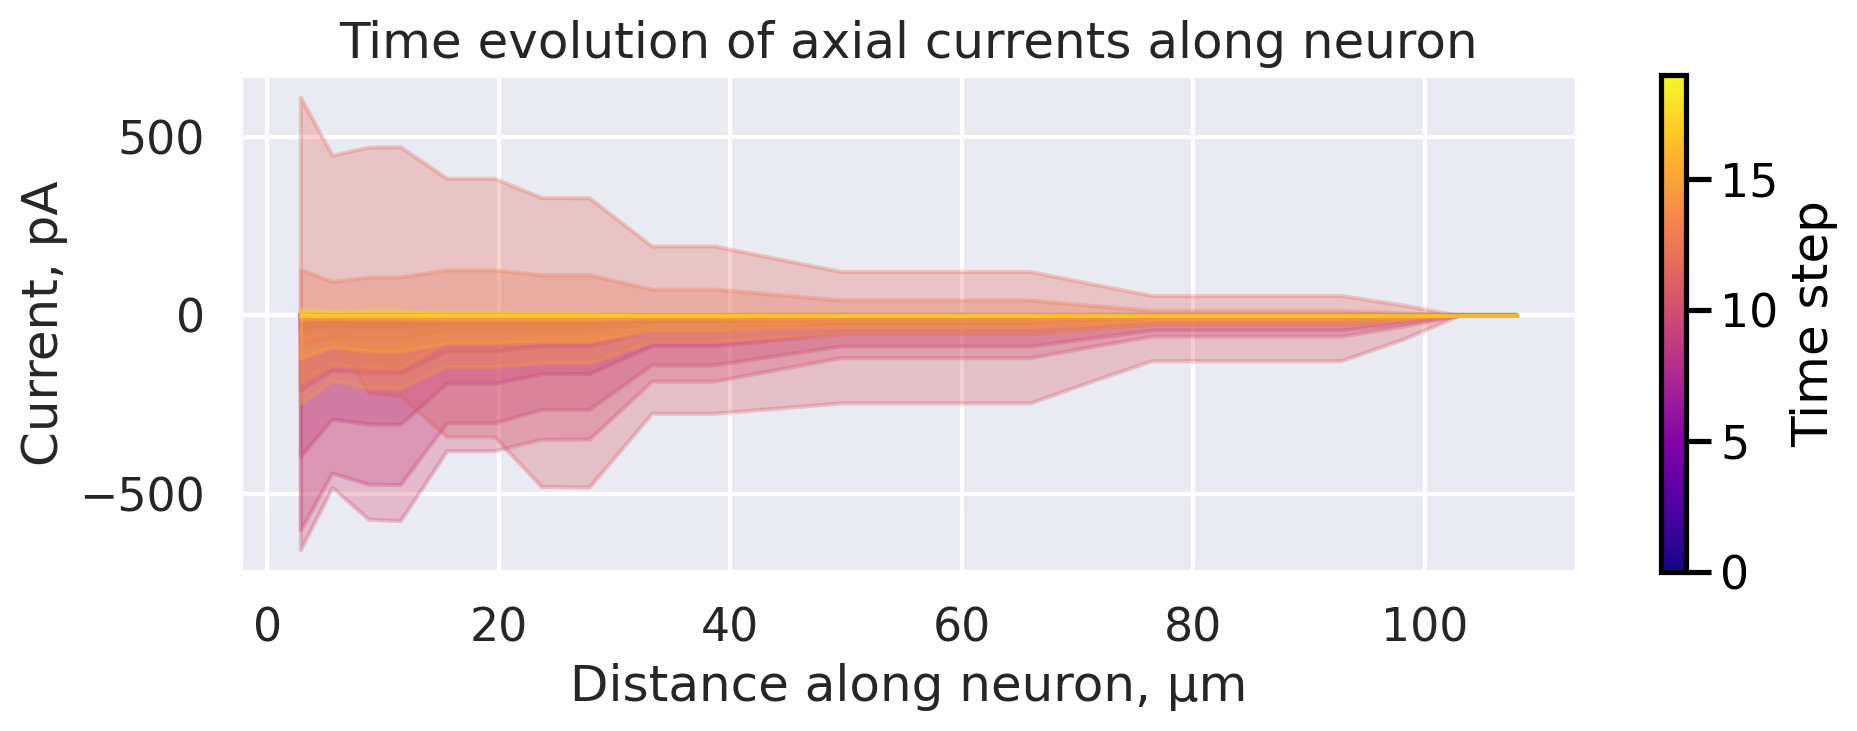

In [14]:
# Set names of the sections to plot   
section_name = "apical_dendrite[13]"
parent_section = n.get(section_name).trueparentseg().sec.hname()
grandparent_section = n.get(parent_section).trueparentseg().sec.hname()

# Get arc lengths for all sections
ls_current = np.array(n.mesh[section_name].field_data["arc_length"])
ls_parent = np.array(n.mesh[parent_section].field_data["arc_length"])
ls_grandparent = np.array(n.mesh[grandparent_section].field_data["arc_length"])

# Create concatenated distance array
ls_combined = np.concatenate([
    ls_grandparent[1:], 
    ls_parent[1:] + ls_grandparent[-1], 
    ls_current[1:] + ls_parent[-1] + ls_grandparent[-1]
])

# Create figure with larger size for better visibility
fig = plt.figure(figsize=(10, 4))

# Get number of segments for all sections
n_segments_current = n.record[section_name]["currents"].shape[0]
n_segments_parent = n.record[parent_section]["currents"].shape[0]
n_segments_grandparent = n.record[grandparent_section]["currents"].shape[0]

n_times = 20
n_time_points = n.record["t"].shape[0]
time_points = np.arange(0, n_time_points, n_times)

# Create color palette that varies sequentially
colors = sns.color_palette("plasma", n_times)

sns.set_context("talk")
sns.set_palette("colorblind")

# Plot each time step with filled area
with sns.axes_style("darkgrid"):
    for j in range(n_times):
        # Get currents for all sections
        currents_grandparent = n.record[grandparent_section]["currents"][:, time_points[j]] * 1e9  # convert mA → pA
        currents_parent = n.record[parent_section]["currents"][:, time_points[j]] * 1e9
        currents_current = n.record[section_name]["currents"][:, time_points[j]] * 1e9
        
        # Concatenate currents
        currents_combined = np.concatenate([currents_grandparent, currents_parent, currents_current])
        
        # Plot filled area
        plt.fill_between(ls_combined, 
                        currents_combined,
                        alpha=0.3,  # Make it semi-transparent
                        color=colors[j],
                        label=f't = {time_points[j]:.1f} ms')

# Customize plot
plt.xlabel('Distance along neuron, μm')
plt.ylabel('Current, pA')
plt.title('Time evolution of axial currents along neuron')

# Get current axis
ax = plt.gca()


# Add a colorbar to show time evolution
norm = plt.Normalize(0, n_times-1)
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Time step')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

In [32]:
sec.diam

1.3500000238418577

In [54]:
n.h.units("ko")

'mM'

In [173]:
pts = RegularGridSensor(bounds=(-10, 10, 0, 0, -10, 10), resolution=[200, 1, 200])
current_pts = np.array([[0, 0, 0], [0, 0, 1]], dtype=np.float64)
B = get_b_njit(current_pts=current_pts, pts=pts.points, current=np.array([[1]], dtype=np.float64)) 
# if current is in nA, then
# B in nT

In [174]:
pts["B"] = B[:, :, 0].T

In [141]:
from magrec.misc.sampler import GridSampler

In [147]:
from magrec.misc.plot import plot_n_components

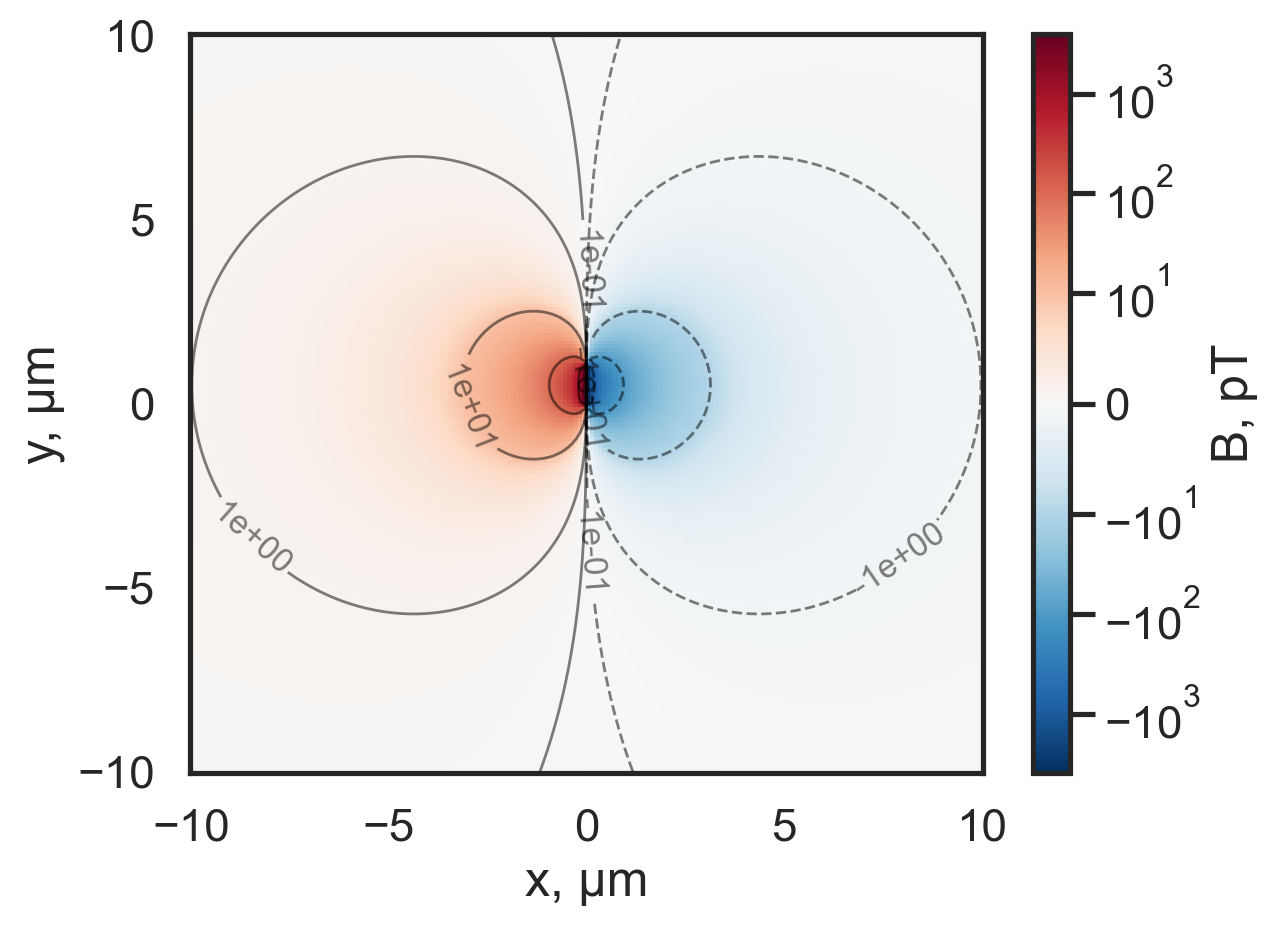

In [216]:
import matplotlib as mpl

sns.set_style("white")
sns.set_context("talk")
sns.set_palette("colorblind")

# Create the data for the plot
x = np.linspace(-10, 10, 200)
y = np.linspace(-10, 10, 200)
data = GridSampler.pts_to_grid(pts["B"], 200, 200)[1, :, :] * 1e3


plt.plot()
fig, ax = plt.subplots()
pcm = ax.pcolormesh(
    np.linspace(-10, 10, 200),
    np.linspace(-10, 10, 200),
    GridSampler.pts_to_grid(pts["B"], 200, 200)[1, :, :] * 1e3,
    cmap="RdBu_r",
    norm=mpl.colors.SymLogNorm(linthresh=1e1, linscale=1)
)

# Add contour lines
# Create levels for both positive and negative values
levels = np.sort(np.concatenate([
    -np.logspace(-1, 4, 6),  # Negative values
    np.logspace(-1, 4, 6)    # Positive values
]))
contour = ax.contour(x, y, data, levels=levels, colors='k', alpha=0.5, linewidths=1)
ax.clabel(contour, inline=True, fontsize=12, fmt='%.0e')
plt.xlabel("x, μm")
plt.ylabel("y, μm")

fig.colorbar(pcm, ax=ax, label="B, pT")
fig

In [205]:
mpl.pyplot.close()